In [1]:
import numpy as np
import csv
import glob
import os.path
from os import path
from datetime import datetime
import matplotlib.pyplot as plt
from alphaengine import loaders, stats

In [2]:
import talib

In [3]:
# The basic CSV instrument. We'll abstract this later when we need it
class FileInstrument:
    def __init__(self, filename, load=True):
        self.datetime_format = '%Y-%m-%d %H:%M:%S'
        self.column_names = ['day', 'month', 'year', 'hour', 'minute', 'second', 'open', 'high', 'low', 'close', 'volume', 'forward_returns']
        self.column_set = set(self.column_names)
        
        self.data = None
        
        if load:
            self.load_file(filename)
        
    def load_file(self, filename):
        with open(filename) as f:
            item = []
            reader = csv.reader(f)
            for row in reader:
                _row = self.format_row(*row)
                item.append(_row)
                
        item = np.array(item)
        returns = np.expand_dims(np.diff(item[:,-2], append=item[:,-2][-1]), axis=1)
        
        items_with_returns = np.hstack((item, returns))
        self.data = items_with_returns
        
    def format_row(self, *args):
        date = datetime.strptime(args[0], self.datetime_format)
        o = float(args[1])
        h = float(args[2])
        l = float(args[3])
        c = float(args[4])
        v = int(args[5])

        return [date.day, date.month, date.year, date.hour, date.minute, date.second, o, h, l, c, v]
    
    def attach_feature(self, feature, name):
        self.column_set.add(name) # this will fail if the feature already exists
        self.column_names.append(name)
        
        f = np.expand_dims(feature, axis=1)
        self.data = np.hstack((self.data, f))
    
    def __getitem__(self, key):
        if type(key) == str:
            idx = self.column_names.index(key)
            return self.data[:,idx]
        
        return self.data.__getitem__(key)

    def __repr__(self):
        return self.data.__repr__()

In [4]:
luv = FileInstrument('../../../Developer/Data/FirstRateData/DIA_2000_2009.txt')

In [5]:
d = np.diff(luv['close'], prepend=luv['close'][0])

In [6]:
luv.attach_feature(d, 'back_returns')

In [7]:
luv['back_returns']

array([ 0.  , -0.02, -0.04, ...,  0.  ,  0.  ,  0.  ])

In [8]:
def run_monte_single(asset, idx, samples=70000, simulations=1000):
    returns = asset['forward_returns'][idx]
    mcs = np.stack([np.cumsum(np.random.choice(returns, samples)) for i in range(simulations)])
    return mcs

In [9]:
mc = run_monte_single(luv, luv['back_returns'] < talib.EMA(luv['back_returns']))

In [10]:
plt.plot(mc.T)

Error in callback <function flush_figures at 0x7fb4557e6048> (for post_execute):


KeyboardInterrupt: 

In [11]:
vanilla = run_monte_single(luv, np.random.choice([True, False], size=len(luv[:,0]), p=[1, 0]))

(array([ 1.,  2.,  0.,  0.,  1.,  3.,  5.,  2.,  1.,  9.,  8., 14., 13.,
        12., 12., 17., 25., 31., 38., 32., 47., 41., 43., 46., 49., 43.,
        57., 53., 41., 43., 38., 39., 36., 30., 28., 28., 20., 17., 17.,
         9., 17., 10.,  6.,  5.,  2.,  6.,  2.,  0.,  0.,  1.]),
 array([ 56.0375 ,  58.38789,  60.73828,  63.08867,  65.43906,  67.78945,
         70.13984,  72.49023,  74.84062,  77.19101,  79.5414 ,  81.89179,
         84.24218,  86.59257,  88.94296,  91.29335,  93.64374,  95.99413,
         98.34452, 100.69491, 103.0453 , 105.39569, 107.74608, 110.09647,
        112.44686, 114.79725, 117.14764, 119.49803, 121.84842, 124.19881,
        126.5492 , 128.89959, 131.24998, 133.60037, 135.95076, 138.30115,
        140.65154, 143.00193, 145.35232, 147.70271, 150.0531 , 152.40349,
        154.75388, 157.10427, 159.45466, 161.80505, 164.15544, 166.50583,
        168.85622, 171.20661, 173.557  ]),
 <a list of 50 Patch objects>)

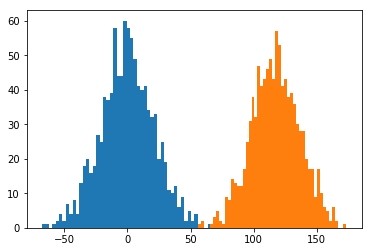

In [12]:
plt.hist(vanilla[:,-1], bins=50)
plt.hist(mc[:,-1], bins=50)

In [113]:
strat = luv['back_returns'] < talib.EMA(luv['back_returns'])

In [114]:
performance = strat.astype(int) * luv['forward_returns']

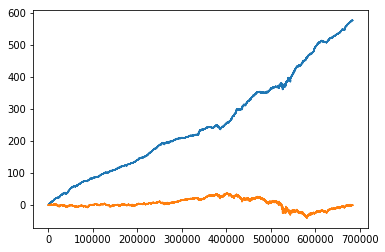

In [115]:
plt.plot(np.cumsum(performance))
plt.plot(np.cumsum(luv['forward_returns']))

In [96]:
time_in_market = np.sum(strat.astype(int)) / len(strat)

In [97]:
strat_perf = np.cumsum(performance)
buy_hold_perf = np.cumsum(luv['forward_returns'])

In [98]:
strat_v_bh = strat_perf[-1] / buy_hold_perf[-1]

In [99]:
print(f'Time in the market: \t\t{time_in_market*100:.2f}%')
print(f'Performance against BH: \t{strat_v_bh*100:.2f}%')
print(f'Volatility efficiency: \t\t{(strat_v_bh / time_in_market)*100:.2f}%')

Time in the market: 		50.35%
Performance against BH: 	-55284.83%
Volatility efficiency: 		-109800.98%


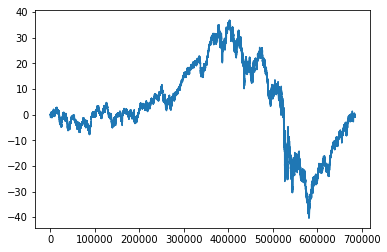

In [83]:
plt.plot(np.cumsum(luv['forward_returns']))